# Figures for Section II: Non-IID Data in Federated Learning

**Purpose:** Generate reproducible, slide-ready figures for Section II lectures and documentation.

## Output Structure

All figures are saved to: `figures/section2/`

### Figure List

1. **s2_01_iid_vs_noniid** - Two-panel comparison of IID vs Non-IID label distributions
2. **s2_02_heterogeneity_examples** - Three types of heterogeneity illustrated
3. **s2_03_effects_conflict_vectors** - Visualization of client drift and conflicting updates
4. **s2_04_measure_heatmap** - Heatmap with heterogeneity metrics

### Format

- Vector: SVG and PDF (for slides/LaTeX)
- Raster: PNG at 300 DPI (fallback)

## 1. Environment Setup and Plotting Style

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from pathlib import Path
from scipy.stats import entropy

# Set matplotlib style for slides
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.titlesize': 18,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 2,
})

# Output directory
OUT_DIR = Path('figures/section2')
OUT_DIR.mkdir(parents=True, exist_ok=True)

def savefig(name, formats=['svg', 'pdf', 'png']):
    """
    Save current figure in multiple formats.
    
    Args:
        name: Base filename (without extension)
        formats: List of formats to save
    """
    for fmt in formats:
        filepath = OUT_DIR / f"{name}.{fmt}"
        plt.savefig(filepath, format=fmt, dpi=300 if fmt == 'png' else None)
        print(f"✓ Saved: {filepath}")

print(f"Output directory: {OUT_DIR.resolve()}")
print("Environment configured successfully.")

Output directory: /home/aaron/T3-Ciders-FL/2_IID_Concepts/figures/section2
Environment configured successfully.


## 2. Global Configuration

In [12]:
# Reproducibility
SEED = 42
np.random.seed(SEED)

# Dataset parameters
N_CLIENTS = 10
N_CLASSES = 10  # MNIST-like (digits 0-9)
SAMPLES_PER_CLIENT = 500  # Average samples per client

# Non-IID parameters
ALPHA_LIST = [100.0, 1.0, 0.3, 0.1, 0.03]  # Dirichlet concentration parameters
# alpha=100 → near IID
# alpha=1.0 → moderate skew
# alpha=0.1 → strong skew
# alpha=0.03 → extreme skew

# Colors for classes (colorblind-friendly)
CLASS_COLORS = plt.cm.tab10(np.linspace(0, 1, N_CLASSES))

print("Configuration:")
print(f"  Seed: {SEED}")
print(f"  Clients: {N_CLIENTS}")
print(f"  Classes: {N_CLASSES}")
print(f"  Avg samples/client: {SAMPLES_PER_CLIENT}")

Configuration:
  Seed: 42
  Clients: 10
  Classes: 10
  Avg samples/client: 500


## 3. Synthetic Label Dataset Generator

Generate client label distributions synthetically (no image data needed).

In [13]:
def generate_global_labels(total_samples, n_classes, prior='uniform', seed=None):
    """
    Generate a pool of labels with specified class prior.
    
    Args:
        total_samples: Total number of samples
        n_classes: Number of classes
        prior: 'uniform' or array of probabilities
        seed: Random seed
    
    Returns:
        labels: Array of shape (total_samples,) with class labels
    """
    if seed is not None:
        np.random.seed(seed)
    
    if prior == 'uniform':
        p_global = np.ones(n_classes) / n_classes
    else:
        p_global = np.array(prior)
        p_global = p_global / p_global.sum()
    
    labels = np.random.choice(n_classes, size=total_samples, p=p_global)
    return labels

def counts_to_distribution(counts):
    """
    Convert counts to probability distributions (per client).
    
    Args:
        counts: Array of shape (n_clients, n_classes)
    
    Returns:
        distributions: Array of shape (n_clients, n_classes) with row sums = 1
    """
    row_sums = counts.sum(axis=1, keepdims=True)
    row_sums = np.where(row_sums == 0, 1, row_sums)  # Avoid division by zero
    return counts / row_sums

print("Label generation utilities defined.")

Label generation utilities defined.


## 4. Partitioning Functions

Implement IID and Non-IID (Dirichlet) partitioning strategies.

In [14]:
def partition_iid(n_clients, n_classes, samples_per_client, seed=None):
    """
    Create IID partition: each client gets uniform class distribution.
    
    Args:
        n_clients: Number of clients
        n_classes: Number of classes
        samples_per_client: Average samples per client
        seed: Random seed
    
    Returns:
        client_class_counts: Array of shape (n_clients, n_classes)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Each client gets approximately equal samples from each class
    counts = np.zeros((n_clients, n_classes), dtype=int)
    
    for client_id in range(n_clients):
        # Sample from uniform distribution
        p_uniform = np.ones(n_classes) / n_classes
        client_samples = np.random.multinomial(samples_per_client, p_uniform)
        counts[client_id] = client_samples
    
    return counts

def partition_dirichlet(n_clients, n_classes, samples_per_client, alpha, seed=None):
    """
    Create Non-IID partition using Dirichlet distribution.
    
    Args:
        n_clients: Number of clients
        n_classes: Number of classes
        samples_per_client: Average samples per client
        alpha: Dirichlet concentration parameter (smaller = more skew)
        seed: Random seed
    
    Returns:
        client_class_counts: Array of shape (n_clients, n_classes)
    """
    if seed is not None:
        np.random.seed(seed)
    
    counts = np.zeros((n_clients, n_classes), dtype=int)
    
    # For each class, sample how it's distributed across clients
    for k in range(n_classes):
        # Sample proportions for this class
        proportions = np.random.dirichlet(alpha=np.ones(n_clients) * alpha)
        
        # Allocate class k samples to clients
        class_k_total = samples_per_client * n_clients // n_classes
        class_k_counts = (proportions * class_k_total).astype(int)
        
        # Handle rounding
        remainder = class_k_total - class_k_counts.sum()
        if remainder > 0:
            # Add remainder to clients with highest proportions
            top_clients = np.argsort(proportions)[-remainder:]
            class_k_counts[top_clients] += 1
        
        counts[:, k] = class_k_counts
    
    return counts

def partition_quantity_skew(n_clients, n_classes, total_samples, distribution='lognormal', alpha=1.0, seed=None):
    """
    Create partition with varying client dataset sizes.
    
    Args:
        n_clients: Number of clients
        n_classes: Number of classes
        total_samples: Total samples to distribute
        distribution: 'lognormal' or 'powerlaw'
        alpha: Dirichlet parameter for label distribution
        seed: Random seed
    
    Returns:
        client_class_counts: Array of shape (n_clients, n_classes)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Sample client sizes
    if distribution == 'lognormal':
        sizes = np.random.lognormal(mean=5, sigma=1, size=n_clients)
    else:  # powerlaw
        sizes = np.random.power(a=2, size=n_clients)
    
    # Normalize to total_samples
    sizes = (sizes / sizes.sum() * total_samples).astype(int)
    
    # Ensure all clients have at least some samples
    sizes = np.maximum(sizes, 50)
    
    # Allocate labels for each client
    counts = np.zeros((n_clients, n_classes), dtype=int)
    for i, size in enumerate(sizes):
        # Use Dirichlet for label distribution
        p = np.random.dirichlet(alpha=np.ones(n_classes) * alpha)
        counts[i] = np.random.multinomial(size, p)
    
    return counts

print("Partitioning functions defined.")

Partitioning functions defined.


## 5. Plotting Utilities

In [15]:
print("Plotting utilities defined (using inline plotting).")

Plotting utilities defined (using inline plotting).


---

## Figure Generation

---

## 6. Figure s2_01: IID vs Non-IID Comparison

/tmp/ipykernel_279636/162071775.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


✓ Saved: figures/section2/s2_01_iid_vs_noniid.svg
✓ Saved: figures/section2/s2_01_iid_vs_noniid.pdf
✓ Saved: figures/section2/s2_01_iid_vs_noniid.png


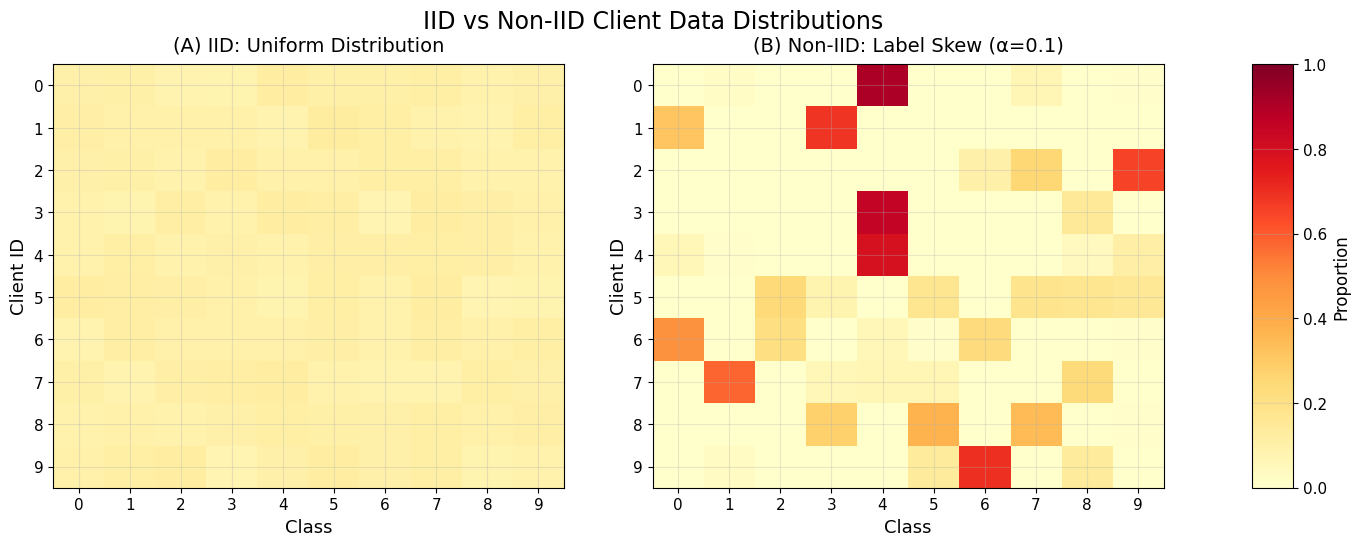


IID total samples: 5000
Non-IID total samples: 5000


In [16]:
# Generate data
counts_iid = partition_iid(
    n_clients=N_CLIENTS,
    n_classes=N_CLASSES,
    samples_per_client=SAMPLES_PER_CLIENT,
    seed=SEED
)

counts_noniid = partition_dirichlet(
    n_clients=N_CLIENTS,
    n_classes=N_CLASSES,
    samples_per_client=SAMPLES_PER_CLIENT,
    alpha=0.1,  # Strong skew for clear visual
    seed=SEED
)

# Create comparison plot with proper spacing for colorbar
fig = plt.figure(figsize=(16, 5.5))
gs = GridSpec(1, 3, width_ratios=[1, 1, 0.08], figure=fig, wspace=0.25)

# Normalize data
data_iid = counts_to_distribution(counts_iid)
data_noniid = counts_to_distribution(counts_noniid)

# Plot panel A
ax0 = fig.add_subplot(gs[0])
im0 = ax0.imshow(data_iid, aspect='auto', cmap='YlOrRd', vmin=0, vmax=1)
ax0.set_xlabel('Class', fontsize=13)
ax0.set_ylabel('Client ID', fontsize=13)
ax0.set_title('(A) IID: Uniform Distribution', fontsize=14, pad=10)
ax0.set_xticks(np.arange(N_CLASSES))
ax0.set_yticks(np.arange(N_CLIENTS))

# Plot panel B
ax1 = fig.add_subplot(gs[1])
im1 = ax1.imshow(data_noniid, aspect='auto', cmap='YlOrRd', vmin=0, vmax=1)
ax1.set_xlabel('Class', fontsize=13)
ax1.set_ylabel('Client ID', fontsize=13)
ax1.set_title('(B) Non-IID: Label Skew (α=0.1)', fontsize=14, pad=10)
ax1.set_xticks(np.arange(N_CLASSES))
ax1.set_yticks(np.arange(N_CLIENTS))

# Colorbar in separate subplot
ax_cbar = fig.add_subplot(gs[2])
cbar = plt.colorbar(im1, cax=ax_cbar)
cbar.set_label('Proportion', fontsize=12)

fig.suptitle('IID vs Non-IID Client Data Distributions', fontsize=17, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
savefig('s2_01_iid_vs_noniid')
plt.show()

print(f"\nIID total samples: {counts_iid.sum()}")
print(f"Non-IID total samples: {counts_noniid.sum()}")

## 7. Figure s2_02: Types of Heterogeneity Examples

/tmp/ipykernel_279636/2495083889.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


✓ Saved: figures/section2/s2_02_heterogeneity_examples.svg
✓ Saved: figures/section2/s2_02_heterogeneity_examples.pdf
✓ Saved: figures/section2/s2_02_heterogeneity_examples.png


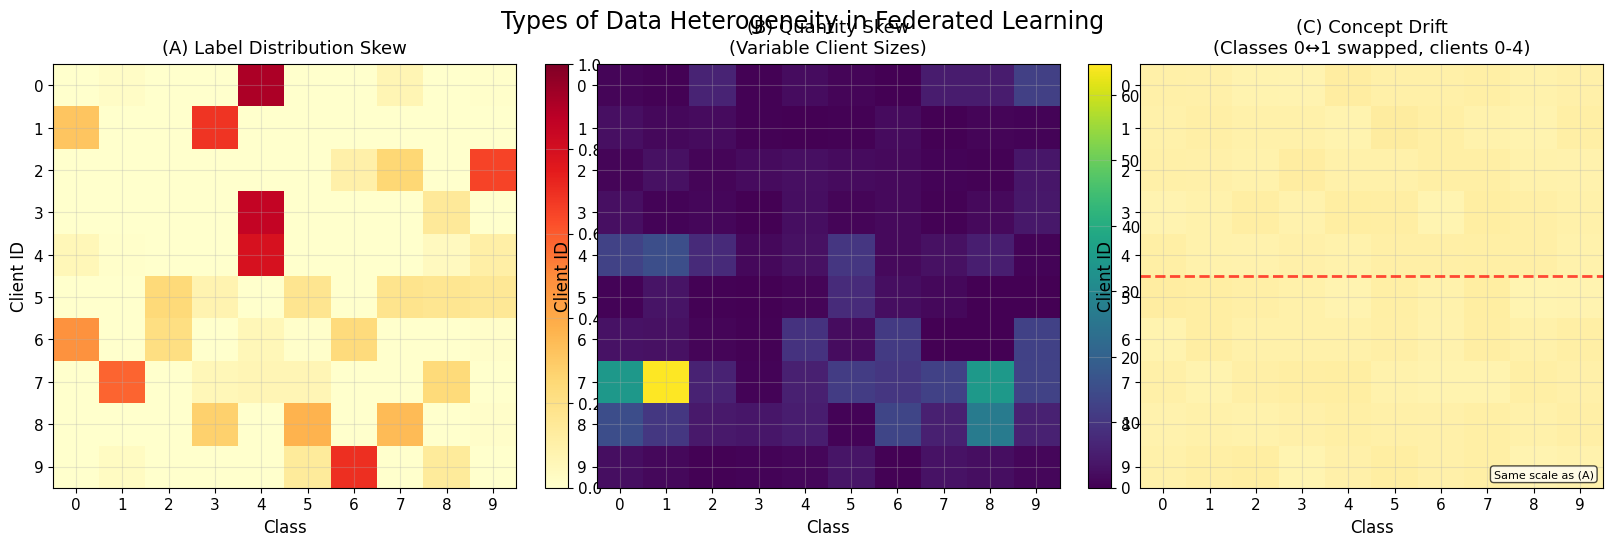

In [17]:
# Generate three types of heterogeneity
counts_label_skew = partition_dirichlet(
    n_clients=N_CLIENTS,
    n_classes=N_CLASSES,
    samples_per_client=SAMPLES_PER_CLIENT,
    alpha=0.1,
    seed=SEED
)

counts_quantity_skew = partition_quantity_skew(
    n_clients=N_CLIENTS,
    n_classes=N_CLASSES,
    total_samples=SAMPLES_PER_CLIENT * N_CLIENTS,
    distribution='lognormal',
    alpha=1.0,  # Uniform labels, but varying sizes
    seed=SEED + 1
)

# Concept drift: simulate by reassigning some classes for half the clients
counts_concept_drift = partition_iid(N_CLIENTS, N_CLASSES, SAMPLES_PER_CLIENT, seed=SEED)
# Swap classes 0↔1 for first half of clients to simulate drift
for i in range(N_CLIENTS // 2):
    counts_concept_drift[i, [0, 1]] = counts_concept_drift[i, [1, 0]]

# Create 3-panel figure with dedicated colorbar space
fig = plt.figure(figsize=(20, 5.5))
gs = GridSpec(1, 5, width_ratios=[1, 0.05, 1, 0.05, 1], figure=fig, wspace=0.1)

# Panel A: Label skew
ax0 = fig.add_subplot(gs[0])
data_a = counts_to_distribution(counts_label_skew)
im0 = ax0.imshow(data_a, aspect='auto', cmap='YlOrRd', vmin=0, vmax=1)
ax0.set_xlabel('Class', fontsize=12)
ax0.set_ylabel('Client ID', fontsize=12)
ax0.set_title('(A) Label Distribution Skew', fontsize=13, pad=8)
ax0.set_xticks(np.arange(N_CLASSES))
ax0.set_yticks(np.arange(N_CLIENTS))

# Colorbar for panel A
cax0 = fig.add_subplot(gs[1])
cbar0 = plt.colorbar(im0, cax=cax0)
cbar0.set_label('Proportion', fontsize=10)

# Panel B: Quantity skew
ax1 = fig.add_subplot(gs[2])
im1 = ax1.imshow(counts_quantity_skew, aspect='auto', cmap='viridis')
ax1.set_xlabel('Class', fontsize=12)
ax1.set_ylabel('Client ID', fontsize=12)
ax1.set_title('(B) Quantity Skew\n(Variable Client Sizes)', fontsize=13, pad=8)
ax1.set_xticks(np.arange(N_CLASSES))
ax1.set_yticks(np.arange(N_CLIENTS))

# Colorbar for panel B
cax1 = fig.add_subplot(gs[3])
cbar1 = plt.colorbar(im1, cax=cax1)
cbar1.set_label('Sample Count', fontsize=10)

# Panel C: Concept drift
ax2 = fig.add_subplot(gs[4])
data_c = counts_to_distribution(counts_concept_drift)
im2 = ax2.imshow(data_c, aspect='auto', cmap='YlOrRd', vmin=0, vmax=1)
ax2.set_xlabel('Class', fontsize=12)
ax2.set_ylabel('Client ID', fontsize=12)
ax2.set_title('(C) Concept Drift\n(Classes 0↔1 swapped, clients 0-4)', fontsize=13, pad=8)
ax2.set_xticks(np.arange(N_CLASSES))
ax2.set_yticks(np.arange(N_CLIENTS))
ax2.axhline(y=4.5, color='red', linestyle='--', linewidth=2, alpha=0.7)

# Note: Panel C uses same colormap as A, so we add a note
ax2.text(0.98, 0.02, 'Same scale as (A)', transform=ax2.transAxes,
         fontsize=8, va='bottom', ha='right',
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

fig.suptitle('Types of Data Heterogeneity in Federated Learning', fontsize=17, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
savefig('s2_02_heterogeneity_examples')
plt.show()

## 8. Figure s2_03: Effects of Non-IID (Conflict Vectors)

✓ Saved: figures/section2/s2_03_effects_conflict_vectors.svg
✓ Saved: figures/section2/s2_03_effects_conflict_vectors.pdf
✓ Saved: figures/section2/s2_03_effects_conflict_vectors.png


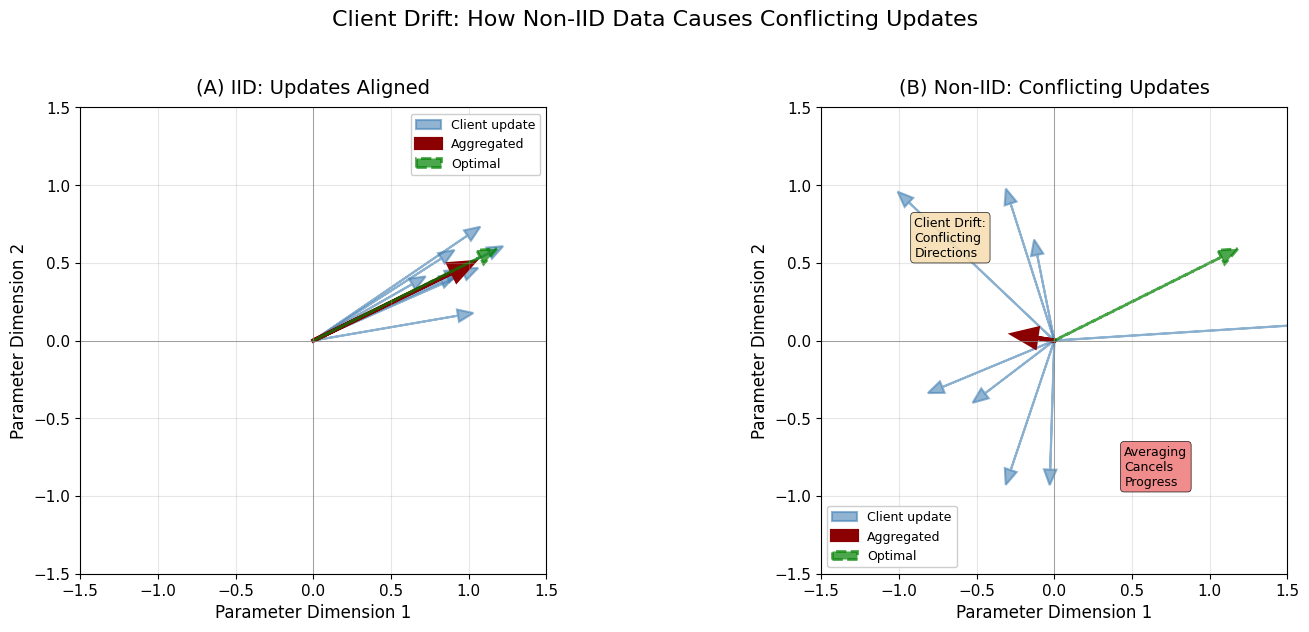


IID aggregated magnitude: 0.997
Non-IID aggregated magnitude: 0.117
Magnitude reduction: 88.2%


In [18]:
# Simulate client update vectors in 2D space
np.random.seed(SEED)

# IID case: updates cluster around optimal direction
n_clients_viz = 8
optimal_direction = np.array([1.0, 0.5])
optimal_direction = optimal_direction / np.linalg.norm(optimal_direction)

# IID updates: small variance around optimal
iid_updates = optimal_direction + np.random.normal(0, 0.15, (n_clients_viz, 2))
iid_mean = iid_updates.mean(axis=0)

# Non-IID updates: large variance, conflicting directions
noniid_updates = np.random.normal(0, 0.8, (n_clients_viz, 2))
# Add bias to some clients in different directions
noniid_updates[:3] += np.array([0.7, 0.3])
noniid_updates[3:5] += np.array([-0.5, 0.8])
noniid_updates[5:] += np.array([0.2, -0.6])
noniid_mean = noniid_updates.mean(axis=0)

# Create side-by-side plot with better spacing and legend placement
fig, axes = plt.subplots(1, 2, figsize=(15, 6.5))
fig.subplots_adjust(wspace=0.25)

# Panel A: IID case
ax = axes[0]
for i, vec in enumerate(iid_updates):
    ax.arrow(0, 0, vec[0], vec[1], head_width=0.08, head_length=0.1,
             fc='steelblue', ec='steelblue', alpha=0.6, linewidth=1.5,
             label='Client update' if i == 0 else '')
ax.arrow(0, 0, iid_mean[0], iid_mean[1], head_width=0.12, head_length=0.15,
         fc='darkred', ec='darkred', linewidth=3, label='Aggregated')
ax.arrow(0, 0, optimal_direction[0]*1.2, optimal_direction[1]*1.2,
         head_width=0.1, head_length=0.12, fc='green', ec='green',
         linewidth=2, linestyle='--', alpha=0.7, label='Optimal')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel('Parameter Dimension 1', fontsize=12)
ax.set_ylabel('Parameter Dimension 2', fontsize=12)
ax.set_title('(A) IID: Updates Aligned', fontsize=14, pad=10)
ax.axhline(0, color='gray', linewidth=0.5, linestyle='-')
ax.axvline(0, color='gray', linewidth=0.5, linestyle='-')
# Move legend to upper right to avoid arrows
ax.legend(loc='upper right', fontsize=9, framealpha=0.95)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Panel B: Non-IID case
ax = axes[1]
for i, vec in enumerate(noniid_updates):
    ax.arrow(0, 0, vec[0], vec[1], head_width=0.08, head_length=0.1,
             fc='steelblue', ec='steelblue', alpha=0.6, linewidth=1.5,
             label='Client update' if i == 0 else '')
ax.arrow(0, 0, noniid_mean[0], noniid_mean[1], head_width=0.12, head_length=0.15,
         fc='darkred', ec='darkred', linewidth=3, label='Aggregated')
ax.arrow(0, 0, optimal_direction[0]*1.2, optimal_direction[1]*1.2,
         head_width=0.1, head_length=0.12, fc='green', ec='green',
         linewidth=2, linestyle='--', alpha=0.7, label='Optimal')

# Add annotations with smaller font and padding, positioned well within bounds
ax.text(-0.9, 0.8, 'Client Drift:\nConflicting\nDirections', fontsize=9,
        ha='left', va='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.9, edgecolor='black', linewidth=0.5))
ax.text(0.45, -0.95, 'Averaging\nCancels\nProgress', fontsize=9,
        ha='left', va='bottom',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.9, edgecolor='black', linewidth=0.5))

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel('Parameter Dimension 1', fontsize=12)
ax.set_ylabel('Parameter Dimension 2', fontsize=12)
ax.set_title('(B) Non-IID: Conflicting Updates', fontsize=14, pad=10)
ax.axhline(0, color='gray', linewidth=0.5, linestyle='-')
ax.axvline(0, color='gray', linewidth=0.5, linestyle='-')
# Move legend to lower left to avoid arrows and annotations
ax.legend(loc='lower left', fontsize=9, framealpha=0.95)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

fig.suptitle('Client Drift: How Non-IID Data Causes Conflicting Updates', fontsize=16, y=0.97)
plt.tight_layout(rect=[0, 0, 1, 0.95])
savefig('s2_03_effects_conflict_vectors')
plt.show()

print(f"\nIID aggregated magnitude: {np.linalg.norm(iid_mean):.3f}")
print(f"Non-IID aggregated magnitude: {np.linalg.norm(noniid_mean):.3f}")
print(f"Magnitude reduction: {(1 - np.linalg.norm(noniid_mean)/np.linalg.norm(iid_mean))*100:.1f}%")

## 9. Figure s2_04: Measuring Non-IID (Heatmap + Metrics)

/tmp/ipykernel_279636/2645644565.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


✓ Saved: figures/section2/s2_04_measure_heatmap.svg
✓ Saved: figures/section2/s2_04_measure_heatmap.pdf
✓ Saved: figures/section2/s2_04_measure_heatmap.png


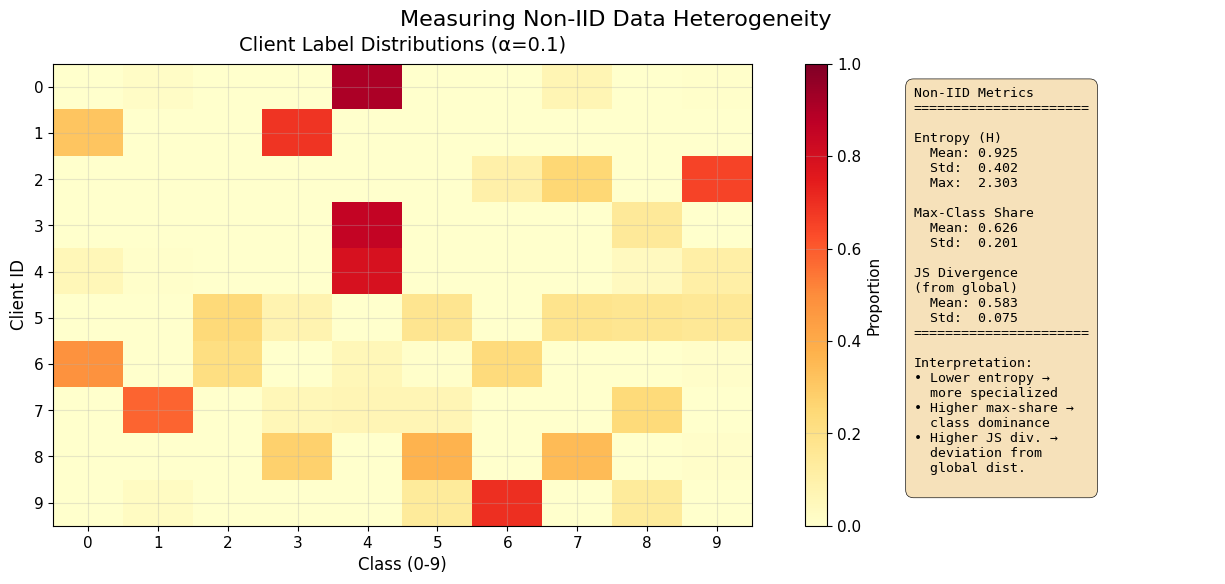


Detailed Metrics:
  Mean Entropy: 0.925 (max possible: 2.303)
  Mean Max-Class Share: 0.626 (1.0 = complete specialization)
  Mean JS Divergence: 0.583 (0 = identical to global)


In [19]:
# Generate Non-IID data
counts_noniid_measure = partition_dirichlet(
    n_clients=N_CLIENTS,
    n_classes=N_CLASSES,
    samples_per_client=SAMPLES_PER_CLIENT,
    alpha=0.1,
    seed=SEED
)

# Compute metrics
distributions = counts_to_distribution(counts_noniid_measure)

# 1. Entropy per client
entropies = np.array([entropy(dist) for dist in distributions])
mean_entropy = entropies.mean()
std_entropy = entropies.std()

# 2. Max-class share per client
max_shares = distributions.max(axis=1)
mean_max_share = max_shares.mean()
std_max_share = max_shares.std()

# 3. Global distribution
global_dist = counts_noniid_measure.sum(axis=0)
global_dist = global_dist / global_dist.sum()

# 4. JS divergence from global
from scipy.spatial.distance import jensenshannon
js_divergences = np.array([jensenshannon(dist, global_dist) for dist in distributions])
mean_js = js_divergences.mean()
std_js = js_divergences.std()

# Create figure with heatmap + metrics panel using GridSpec
fig = plt.figure(figsize=(15, 6))
gs = GridSpec(1, 3, width_ratios=[2.5, 0.08, 1.2], figure=fig, wspace=0.15)

# Left panel: Heatmap
ax_heat = fig.add_subplot(gs[0])
im = ax_heat.imshow(distributions, aspect='auto', cmap='YlOrRd', vmin=0, vmax=1)
ax_heat.set_xlabel('Class (0-9)', fontsize=12)
ax_heat.set_ylabel('Client ID', fontsize=12)
ax_heat.set_title('Client Label Distributions (α=0.1)', fontsize=14, pad=10)
ax_heat.set_xticks(np.arange(N_CLASSES))
ax_heat.set_yticks(np.arange(N_CLIENTS))

# Colorbar in dedicated subplot
ax_cbar = fig.add_subplot(gs[1])
cbar = plt.colorbar(im, cax=ax_cbar)
cbar.set_label('Proportion', fontsize=11)

# Right panel: Metrics
ax_metrics = fig.add_subplot(gs[2])
ax_metrics.axis('off')

metrics_text = f"""Non-IID Metrics
{'='*22}

Entropy (H)
  Mean: {mean_entropy:.3f}
  Std:  {std_entropy:.3f}
  Max:  {np.log(N_CLASSES):.3f}

Max-Class Share
  Mean: {mean_max_share:.3f}
  Std:  {std_max_share:.3f}

JS Divergence
(from global)
  Mean: {mean_js:.3f}
  Std:  {std_js:.3f}
{'='*22}

Interpretation:
• Lower entropy →
  more specialized
• Higher max-share →
  class dominance
• Higher JS div. →
  deviation from
  global dist.
"""

ax_metrics.text(0.1, 0.95, metrics_text, transform=ax_metrics.transAxes,
               fontsize=9.5, verticalalignment='top', family='monospace',
               bbox=dict(boxstyle='round,pad=0.6', facecolor='wheat', alpha=0.9, 
                        edgecolor='black', linewidth=0.5))

fig.suptitle('Measuring Non-IID Data Heterogeneity', fontsize=16, y=0.97)
plt.tight_layout(rect=[0, 0, 1, 0.95])
savefig('s2_04_measure_heatmap')
plt.show()

print("\nDetailed Metrics:")
print(f"  Mean Entropy: {mean_entropy:.3f} (max possible: {np.log(N_CLASSES):.3f})")
print(f"  Mean Max-Class Share: {mean_max_share:.3f} (1.0 = complete specialization)")
print(f"  Mean JS Divergence: {mean_js:.3f} (0 = identical to global)")

---

## Summary and Export Verification

In [20]:
import os
from pathlib import Path

print("\n" + "="*60)
print("Figure Generation Complete!")
print("="*60)

# List generated files
output_dir = Path('figures/section2')
files = sorted(output_dir.glob('*'))

print(f"\nGenerated {len(files)} files in: {output_dir.resolve()}\n")

# Group by base name
file_groups = {}
for f in files:
    base = f.stem
    ext = f.suffix
    if base not in file_groups:
        file_groups[base] = []
    file_groups[base].append(ext)

for base, exts in sorted(file_groups.items()):
    print(f"  ✓ {base}")
    for ext in sorted(exts):
        size_kb = (output_dir / f"{base}{ext}").stat().st_size / 1024
        print(f"      {ext:6s}  {size_kb:>8.1f} KB")

print("\n" + "="*60)
print("All figures are ready for slides and documentation!")
print("="*60)


Figure Generation Complete!

Generated 12 files in: /home/aaron/T3-Ciders-FL/2_IID_Concepts/figures/section2

  ✓ s2_01_iid_vs_noniid
      .pdf        48.1 KB
      .png       150.4 KB
      .svg        93.2 KB
  ✓ s2_02_heterogeneity_examples
      .pdf        80.5 KB
      .png       219.9 KB
      .svg       138.9 KB
  ✓ s2_03_effects_conflict_vectors
      .pdf        17.3 KB
      .png       347.3 KB
      .svg        74.6 KB
  ✓ s2_04_measure_heatmap
      .pdf        63.0 KB
      .png       269.6 KB
      .svg       113.5 KB

All figures are ready for slides and documentation!
